In [1]:
%pylab inline
from scipy.interpolate import InterpolatedUnivariateSpline

Populating the interactive namespace from numpy and matplotlib


# Calculamos la envolvente y el parámetro de circularidad

In [8]:
Modelo = np.arange(1,7)

for ind in range(0,len(Modelo)):
    ## Leemos los datos de las galaxias
    path = '/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/'
    disk = np.loadtxt(path+'model_disk_final')
    halo = np.loadtxt(path+'model_halo_final')
    bulge = np.loadtxt(path+'model_bulge_final')
    # Las unidades son: kpc, M_sun, km/s

    pos = np.vstack((halo[:,:3],disk[:,:3],bulge[:,:3]))
    m = (np.hstack((halo[:,6],disk[:,6],bulge[:,6])))/10**10
    ID = np.arange(0,len(m))

    ## Calculamos las componentes de momento angular. Para ello primero rotamos las posiciones y velocidades.

    pos_dark_rot = halo[:,:3]
    vel_dark_rot = halo[:,3:6]

    pos_star_rot = np.vstack((disk[:,:3], bulge[:,:3]))
    vel_star_rot = np.vstack((disk[:,3:6], bulge[:,3:6]))

    L_dark  = np.asarray((pos_dark_rot[:,1]*vel_dark_rot[:,2] - pos_dark_rot[:,2]*vel_dark_rot[:,1], 
                          pos_dark_rot[:,2]*vel_dark_rot[:,0] - pos_dark_rot[:,0]*vel_dark_rot[:,2], 
                          pos_dark_rot[:,0]*vel_dark_rot[:,1] - pos_dark_rot[:,1]*vel_dark_rot[:,0]))
    L_star = np.asarray((pos_star_rot[:,1]*vel_star_rot[:,2] - pos_star_rot[:,2]*vel_star_rot[:,1], 
                          pos_star_rot[:,2]*vel_star_rot[:,0] - pos_star_rot[:,0]*vel_star_rot[:,2], 
                          pos_star_rot[:,0]*vel_star_rot[:,1] - pos_star_rot[:,1]*vel_star_rot[:,0]))

    L_part = np.concatenate((L_dark,L_star),axis=1)

    Lr_star = np.sqrt(L_star[0,:]**2 + L_star[1,:]**2) # Componente en el plano del momento angular de estrellas
    Lr = np.sqrt(L_part[0,:]**2 + L_part[1,:]**2)      # Componente en el plano del momento angular de las particulas

    ## Calculamos la energia cinetica de las partículas
    k_star = 0.5*(vel_star_rot[:,0]**2 + vel_star_rot[:,1]**2 + vel_star_rot[:,2]**2)
    k_dark = 0.5*(vel_dark_rot[:,0]**2 + vel_dark_rot[:,1]**2 + vel_dark_rot[:,2]**2)

    ########################################################################################################################
    ## Leemos los potenciales que guardamos en el archivo
    pot = np.loadtxt('potencial_agama_M'+str(Modelo[ind])+'.dat')
    ########################################################################################################################

    pot_dark = (np.vstack((ID[:len(halo)],pot[:len(halo)]))).T
    pot_star = (np.vstack((ID[len(halo):],pot[len(halo):]))).T

    ## Calculamos la energia
    E_tot_star = k_star - pot_star[:,1]
    E_tot_dark = k_dark - pot_dark[:,1]

    E_tot = np.concatenate((E_tot_dark,E_tot_star))

    ## Nos sacamos de encima las partículas que no están ligadas: E > 0
    neg, = np.where(E_tot <= 0.)
    neg_star, = np.where(E_tot_star <= 0.)

    ## Nos sacamos de encima las partículas con E = -inf
    fin, = np.where(E_tot[neg] != -inf)
    fin_star, = np.where(E_tot_star[neg_star] != -inf)

    ## Normalizamos las dos variables: E entre 0 y 1; L entre -1 y 1
    E = E_tot[neg][fin]/np.abs(np.min(E_tot[neg][fin]))
    L = L_part[2,:][neg][fin]/np.max(np.abs(L_part[2,:][neg][fin]))

    ## Hacemos el bineado en energía y seleccionamos los puntos con los que calculamos la envolvente
    aux0 = np.arange(-1.,-0.3,0.002)
    aux1 = np.arange(-0.3,0.,0.002)

    aux = np.concatenate((aux0,aux1),axis=0)

    x = np.zeros(len(aux)+1)
    y = np.zeros(len(aux)+1)

    x[0] = -1.
    y[0] = np.abs(L[np.argmin(E)])

    for i in range(1,len(aux)):
        mask, = np.where((E <= aux[i]) & (E > aux[i-1]))
        s = np.argsort(np.abs(L[mask]))

        # Aca tenemos en cuenta si en los bines de energia hay o no particulas
        if len(s) != 0: 
            if len(s) == 1:
                x[i] = E[mask][s]
                y[i] = np.abs(L[mask][s])
            else:
                if (1.-(np.abs(L[mask][s][-2])/np.abs(L[mask][s][-1]))) >= 0.01 :
                    x[i] = E[mask][s][-2]
                    y[i] = np.abs(L[mask][s][-2])
                else:
                    x[i] = E[mask][s][-1]
                    y[i] = np.abs(L[mask][s][-1])
        else: pass

    # Mascara para completar el ultimo bin, en caso de que no haya bines vacios
    mask, = np.where(E > aux[len(aux)-1])

    if len(mask) != 0:
        x[len(aux)] = E[mask][np.abs(L[mask]).argmax()]
        y[len(aux)] = np.abs(L[mask][np.abs(L[mask]).argmax()])

    # En el caso en que haya bines vacios, nos deshacemos de ellos
    else:
        i = len(np.where(y == 0)[0]) - 1
        if i == 0:
            x = x[:-1]
            y = y[:-1]
        else:
            x = x[:-i]
            y = y[:-i]

    ## Guardamos los puntos para calcular la envolvente
    stack = np.column_stack((x, y))
    np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/envolvente_M'+str(Modelo[ind])+'.dat', stack, fmt=['%18.14f','%18.14f'])

    # Hacemos la interpolación para calcular la envolvente
    spl = InterpolatedUnivariateSpline(x[:len(y)-5],y[:len(y)-5],k=1)

    ## Normalizamos E, Lz y Lr para las estrellas
    E_star  = E_tot_star[neg_star][fin_star]/np.abs(np.min(E_tot[neg][fin]))
    L_star_ = L_star[2,:][neg_star][fin_star]/np.max(np.abs(L_part[2,:][neg][fin]))
    Lr_star_ = Lr_star[neg_star][fin_star]/np.max(np.abs(Lr[neg][fin]))

    ## Calculamos el parametro de circularidad Lz/Lc
    eps = L_star_/spl(E_star)

    ## Calculamos lo mismo para Lp/Lc
    eps_r = Lr_star_/spl(E_star)

    ## Nos sacamos de encima las partículas que tengan circularidad < -1 y circularidad > 1
    mask, = np.where((eps <= 1.)&(eps >= -1.))

    ## ID de las particulas estelares limpias
    ID_star = np.arange(0,len(k_star))
    ID_star = ID_star[neg_star][fin_star][mask]

    ## Guardamos ID, E y circularidad de las partículas estelares que nos interesan
    indice = np.arange(0,len(ID_star))
    stack = np.column_stack((ID_star, E_star[mask], eps[mask], eps_r[mask],indice))
    np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/circularidad_y_L_M'+str(Modelo[ind])+'.dat', stack, 
               fmt=['%10.0f','%18.14f','%18.14f','%18.14f','%10.0f'])
    

In [ ]:
# # Guardamos ID, E y circularidad de las partículas estelares que nos interesan
# stack = np.column_stack((ID_star, E_star[mask],eps[mask], eps_r[mask],indice))
# np.savetxt('/home/vcristiani/doctorado/test_agama/E_JZ_JP_M'+str(Modelo[ind])+'.dat', stack, 
#            fmt=['%10.0f','%18.14f','%18.14f','%18.14f','%10.0f'])

# Hacemos la descomposición Dinámica con el método Cristiani

In [10]:
Modelo = np.arange(1,7)
path = '/home/vcristiani/doctorado/test_agama/'
ID = np.arange(1,7)

for ind in range(0,len(Modelo)):
    ## Leemos los archivos de la galaxia
    s1 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_disk_final')
    s2 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_bulge_final')
    star = np.vstack((s1,s2))
    star[:,6] = star[:,6]/10**10
        
    ## Leemos ID, E, circularidad, circularidad en el plano de las estrellas de la galaxia e i.
    data = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/circularidad_y_L_M'+str(Modelo[ind])+'.dat')
    
    ## Construimos el histograma del parametro de circularidad
    n_bin = 100
    h = np.histogram(data[:,2],n_bin,range=(-1.,1.))[0]
    edges = np.round(np.histogram(data[:,2],n_bin,range=(-1.,1.))[1],2)
    a_bin = edges[1]-edges[0]
    center = np.histogram(data[:,2],n_bin,range=(-1.,1.))[1][:-1] + a_bin/2.
    cero, = np.where(edges == 0.)
    m = cero[0]
    
    # Creamos un diccionario: n={} donde vamos a guardar los ID de las particulas que cumplan
    # con las restricciones que le ponemos a la máscara. Así luego podemos tener control
    # sobre cuales son las partículas que se seleccionan.
    n = {}

    for i in range(0,n_bin-1):
        mask,= np.where((data[:,2] >= edges[i]) & (data[:,2] < edges[i+1]))
        n['bin'+'%s'%i] = data[:,4][mask]

    mask, = np.where((data[:,2] >= edges[n_bin-1]) & (data[:,2] <= edges[n_bin]))
    n['bin'+'%s'%(len(center)-1)] = data[:,4][mask]
    
    ## Seleccionamos las particulas que pertenecen al esferoide en función del parámetro del circularidad y E
    np.random.seed(10)
    halo3 = {}

    for i in range(0,m):
        halo3['bin'+'%s'%i] = n['bin'+'%s'%i]
    #     print i, len(halo3['bin'+'%s'%(i)])

    if len(h) >= 2*m:
        lim_aux = 0
    else:
        lim_aux = 2*m - len(h)

    for i in range(lim_aux,m):

        if len(n['bin'+'%s'%i]) >= len(n['bin'+'%s'%(2*m-1-i)]):
            halo3['bin'+'%s'%(2*m-1-i)] = n['bin'+'%s'%(2*m-1-i)]
    #         print i
        else:
    #         print i
            nbin_E = 20

            h0, b0 = np.histogram(data[np.int_(n['bin'+'%s'%i]),1], bins=nbin_E, range=(-1.,0.))
            h1, b1 = np.histogram(data[np.int_(n['bin'+'%s'%(2*m-1-i)]),1], bins=nbin_E, range=(-1.,0.))

            aux0 = []

            for j in range(0,nbin_E):
                if h0[j] != 0 :
                    if (h0[j] >= h1[j]):
                        ll, = np.where((data[np.int_(n['bin'+'%s'%(2*m-1-i)]),1] >= b1[j]) & (data[np.int_(n['bin'+'%s'%(2*m-1-i)]),1] < b1[j+1]))
                        aux1 = data[np.int_(n['bin'+'%s'%(2*m-1-i)]),4][ll]
                        aux0 = np.concatenate((aux0,aux1),axis=None)

                    else:
                        ll, = np.where((data[np.int_(n['bin'+'%s'%(2*m-1-i)]),1] >= b1[j]) & (data[np.int_(n['bin'+'%s'%(2*m-1-i)]),1] < b1[j+1]))
                        aux1 = np.random.choice(data[np.int_(n['bin'+'%s'%(2*m-1-i)]),4][ll],h0[j],replace=False)
                        aux0 = np.concatenate((aux0,aux1),axis=None)
                else:
                    aux1 = []
                    aux0 = np.concatenate((aux0,aux1),axis=None)

            halo3['bin'+'%s'%(2*m-1-i)] = aux0

    ## Al resto de las particulas las asignamos al disco
    disco3 = n.copy()

    for i in range(0,m):
        disco3['bin'+'%s'%i] = [] #----> Dejamos vacios los bines que sólo tienen particulas del HALO

    x = set()
    y = set()

    if len(h)>=2*m:
        lim = m
    else:
        lim = len(h)-m

    for i in range(lim,len(halo3)):
        x = set(halo3['bin'+'%s'%i])
        y = set(n['bin'+'%s'%i])
        y -= x
        y = np.array(list(y))
        disco3['bin'+'%s'%i] = y
        
    ## Guardamos los indices de las particulas que pertenecen al esferoide y al disco, 
    ## que estan en el archivo cirularidad_y_L_ID_str(ID).dat
    esf_ = []
    for i in range(len(halo3)):
        esf_ = np.concatenate((esf_,halo3['bin'+'%s'%(i)]))
    esf_ = np.int_(esf_)

    disk_ = []
    for i in range(len(disco3)):
        disk_ = np.concatenate((disk_,disco3['bin'+'%s'%(i)]))
    disk_ = np.int_(disk_)

####################################################################################################################################################
#     ## Construimos el disco fino teorico
#     from thin_teo import *
#     npbin, thin_teo = thin_teo(data[disk_,2],n_bin,0.2)

#     ## En el programa viejo: d1[:,0] = eps   -----> data[:,2]
#     ##                       d1[:,1] = E     -----> data[:,1]
#     ##                       d1[:,2] = eps_r -----> data[:,3]
#     ##                       d1[:,3] = i     -----> data[:,4]
    
#     arg0 = np.argmax(np.histogram(data[disk_,2],bins=n_bin,range=(-1.,1.))[0])
#     arg1 = np.argmax(np.histogram(thin_teo,bins=n_bin,range=(-1.,1.))[0])

#     cte = np.float(np.histogram(data[disk_,2],bins=n_bin,range=(-1.,1.))[0][arg0])/np.float(np.histogram(thin_teo,bins=n_bin,range=(-1.,1.))[0][arg1])

#     npbin_ = cte*npbin

#     ## Selecionamos las particulas que van a ser del disco fino
#     np.random.seed(10)
#     fino_cristiani = {}

#     for i in range(0,len(disco3)):
#         if len(disco3['bin'+'%s'%+i]) <= npbin_[i]:
#             fino_cristiani['bin'+'%s'%i] = disco3['bin'+'%s'%i]
#         else:
#             fino_cristiani['bin'+'%s'%i] = np.random.choice(disco3['bin'+'%s'%i],np.int(npbin_[i]),replace=False)

#     ## Todo lo que resta se lo asignamos al disco grueso
#     grueso_cristiani = disco3.copy()

#     x = set()
#     y = set()

#     for i in range(0,len(disco3)):
#         x = set(fino_cristiani['bin'+'%s'%i])
#         y = set(disco3['bin'+'%s'%i])
#         y -= x
#         y = np.array(list(y))
#         grueso_cristiani['bin'+'%s'%i] = y

#     thin_cristiani = []
#     for i in range(len(fino_cristiani)):
#         thin_cristiani = np.concatenate((thin_cristiani,fino_cristiani['bin'+'%s'%(i)]))
#     thin_cristiani = np.int_(thin_cristiani)

#     thick_cristiani = []
#     for i in range(len(grueso_cristiani)):
#         thick_cristiani = np.concatenate((thick_cristiani,grueso_cristiani['bin'+'%s'%(i)]))
#     thick_cristiani = np.int_(thick_cristiani)

####################################################################################################################################################

    ## Para obtener posiciones, masas y velocidades del archivo de la simulación usar:
    esferoide = np.int_(data[esf_,0])
    disco = np.int_(data[disk_,0])
#     disco_fino = data[thin_cristiani,0]
#     disco_grueso = data[thick_cristiani,0]
    ## estos indices corresponden al archivo de la simulación original
    
    ## Guardamos los indices de las particulas estelares para cada una de las componentes
    np.savetxt(path+'desc_dina/esf_M'+str(ID[ind])+'.dat', esferoide, fmt=['%18.0f'])
    np.savetxt(path+'desc_dina/dsk_M'+str(ID[ind])+'.dat', disco, fmt=['%18.0f'])
    
#     np.savetxt(path+'TNG_desc_dinam/dsk_thin_ID_'+str(ID[ind])+'.dat', disco_fino, fmt=['%10.0f'])
#     np.savetxt(path+'TNG_desc_dinam/dsk_thick_ID_'+str(ID[ind])+'.dat', disco_grueso, fmt=['%10.0f'])
    
    ## Guardamos los indices de los parametros de circularidad para cada una de las componentes:
    np.savetxt(path+'desc_dina/circularidad_esf_M'+str(ID[ind])+'.dat', esf_, fmt=['%18.0f'])
    np.savetxt(path+'desc_dina/circularidad_dsk_M'+str(ID[ind])+'.dat', disk_, fmt=['%18.0f'])

#     np.savetxt(path+'TNG_circularidad_componentes/circularidad_dsk_thin_ID_'+str(ID[ind])+'.dat', thin_cristiani, fmt=['%10.0f'])
#     np.savetxt(path+'TNG_circularidad_componentes/circularidad_dsk_thick_ID_'+str(ID[ind])+'.dat', thick_cristiani, fmt=['%10.0f'])


# Calculemos el radio a mitad de masa y la masa dentro de 3*R_half

In [11]:
path = '/home/vcristiani/doctorado/test_agama/'
ID = np.arange(1,7)
M_tot = np.zeros(len(ID))
R = np.zeros(len(ID))

for ind in range(0,len(ID)):
    ## Leemos los archivos de la galaxia
    s1 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_disk_final')
    s2 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_bulge_final')
    star = np.vstack((s1,s2))
    star[:,6] = star[:,6]/10**10
    
    ## Calculamos la mitad de masa estelar total
    m = np.sum(star[:,6])/2.
    
    ## Calculamos los radios de las estrellas
    r = np.sqrt(star[:,0]**2 + star[:,1]**2 + star[:,2]**2)
    sort = np.argsort(r) #---> orden de los indices de r, cuando ordenamos r a de menor a mayor
    m_acum = np.cumsum(star[:,6][sort]) #---> calculamos la funcion de masa acumulada
    mask, = np.where(m_acum <= m) #---> con esto buscamos en que particula se alcanza la mitad de la masa
    R[ind] = r[sort][mask][-1] #---> radio a mitad de masa estelar
    
    ## Calculamos la masa estelar dentro 3 veces el radio a mitad de masa
    mask_r, = np.where(r <= 3.*R[ind])
    M_tot[ind] = np.sum(star[mask_r][:,6])
    
data = np.column_stack((ID,M_tot,R))
np.savetxt(path+'masa_y_R.dat', data, fmt=['%8.f','%12.8f','%12.8f'])

# Veamos la distribucion $\epsilon$ vs E para las particulas estelares dentro de $3R_{half}$

/home/vcristiani/packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log10
/home/vcristiani/packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log10


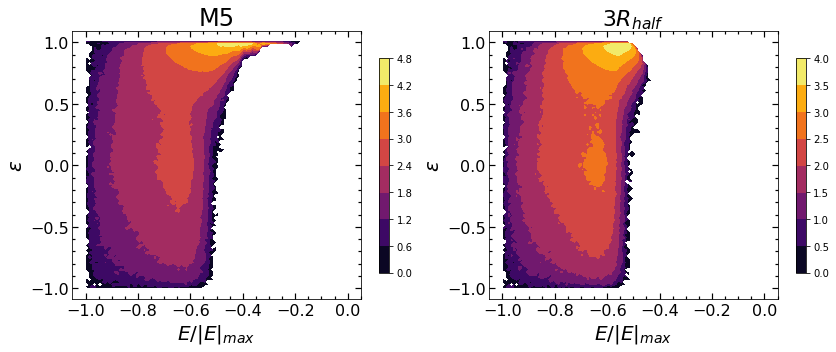

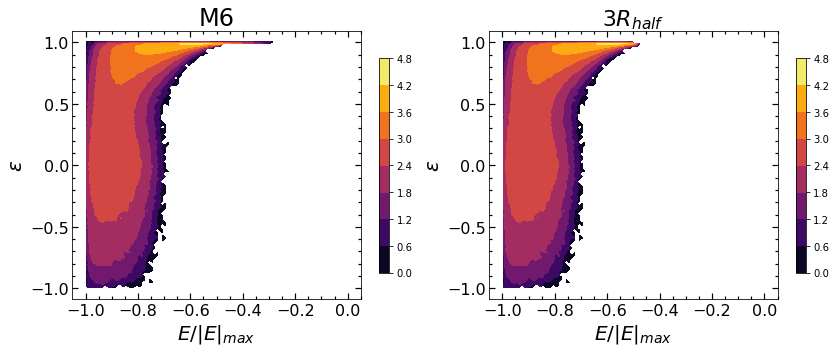

In [13]:
path = '/home/vcristiani/doctorado/test_agama/'
aux = np.loadtxt(path+'masa_y_R.dat')
R = aux[:,2]
M = aux[:,1]

Modelo = np.arange(1,7)

for ind in range(0,len(Modelo)):
    ## Leemos las estrellas de la galaxia
    s1 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_disk_final')
    s2 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_bulge_final')
    star = np.vstack((s1,s2))
#     star[:,6] = star[:,6]/10**10
    
    ## Leemos los resultados de la descomposición dinámica del espacio circularidad - energia
    data = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/circularidad_y_L_M'+str(Modelo[ind])+'.dat')

    ## Calculamos la masa estelar total dentro de 3R_half
    r = np.sqrt(star[np.int_(data[:,0]),0]**2 + star[np.int_(data[:,0]),1]**2 + star[np.int_(data[:,0]),2]**2)
    corte_3R, = np.where(r <= 3.*R[ind])

    ## Hacemos los plots de isocontornos de las dos componentes que separamos
    
    ## Construimos el grid con el que vamos a hacer los isocontornos
    ## Numero de celdas
    cel = 100.
    ## Limites
    xmin = -1.0
    xmax = 0.0
    ymin = -1.0
    ymax = 1.0

    ## Centros del grid
    xx = np.arange(0,np.int(cel)+1)*(xmax-xmin)/cel + xmin + (xmax-xmin)/(cel*2.)
    yy = np.arange(0,np.int(cel)+1)*(ymax-ymin)/cel + ymin + (ymax-ymin)/(cel*2.)

    ## Matriz donde vamos a guardar la suma de las particulas en cada celda
    Z1 = np.zeros((np.int(cel)+1,np.int(cel)+1))
    Z2 = np.zeros((np.int(cel)+1,np.int(cel)+1))
    
    ## Hacemos los plots de los isocontornos
    fig, ax1 = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
    
    ## Veamos los indices de las celdas donde cae cada particula del esferoide
    i_x = np.int_(((data[:,1]-xmin)/ (xmax-xmin))*cel)
    i_y = np.int_(((data[:,2]-ymin)/ (ymax-ymin))*cel)

    ## Sumemos las contribuciones que hacen las particulas en cada celda
    for i in range(0,len(i_x)):
        Z1[i_y[i],i_x[i]] = Z1[i_y[i],i_x[i]] + 1

    CS = ax1[0].contourf(xx, yy, np.log10(Z1),cmap='inferno')
    fig.colorbar(CS, ax=ax1[0],shrink=0.8,extend='both')
    ax1[0].set_title(r'M'+str('%1.0f'%ID[ind]),fontsize=24,color='k')
    
    ## Veamos los indices de las celdas donde cae cada particula del disco
    i_x = np.int_(((data[corte_3R,1]-xmin)/ (xmax-xmin))*cel)
    i_y = np.int_(((data[corte_3R,2]-ymin)/ (ymax-ymin))*cel)
    
    ## Sumemos las contribuciones que hacen las particulas en cada celda
    for i in range(0,len(i_x)):
            Z2[i_y[i],i_x[i]] = Z2[i_y[i],i_x[i]] + 1
    
    CS = ax1[1].contourf(xx, yy, np.log10(Z2),cmap='inferno')
    fig.colorbar(CS, ax=ax1[1],shrink=0.8,extend='both')
    ax1[1].set_title(r'$3R_{half}$',fontsize=22,color='k')
    
    for i in range(0,2):
        ax1[i].set_xlabel(r'$E/|E|_{max}$', fontsize=20)
        ax1[i].set_ylabel(r'$\epsilon$',fontsize=20)
        ax1[i].set_xlim(-1.05,0.05)
        ax1[i].set_ylim(-1.09,1.09)    
    
    for i in range(0,2):
        ax1[i].minorticks_on()
        ax1[i].tick_params(labelsize=16)
        ax1[i].tick_params('both', length=3, width=1.2,which='minor', direction='in', right=True,top=True)
        ax1[i].tick_params('both', length=6, width=1.2,which='major', direction='in', right=True,top=True) 

    fig.savefig('/home/vcristiani/doctorado/test_agama/plot/circ_energia_M'+str(Modelo[ind])+'.png', dpi = 100)

    plt.show()    

# Fracción de Masa de los modelos

In [14]:
Modelo = np.arange(1,7)

frac_masa_esf = np.zeros((len(Modelo),4))
frac_masa_dsk = np.zeros((len(Modelo),4))

frac_masa_esf_3R = np.zeros((len(Modelo),4))
frac_masa_dsk_3R = np.zeros((len(Modelo),4))


In [15]:
# path = '/home/vcristiani/doctorado/test_agama/'
# aux = np.loadtxt(path+'masa_y_R.dat')
# R = aux[:,2]
# M = aux[:,1]

# for ind in range(0,len(Modelo)):    
#     ## Leemos las estrellas de la galaxia
#     s1 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_disk_final')
#     s2 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_bulge_final')
#     star = np.vstack((s1,s2))
    
#     ## Leemos los ID de las particulas estelares que entran en la descomposicion dinamica
#     data = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/circularidad_y_L_M'+str(Modelo[ind])+'.dat')
#     data[:,0] = np.int_(data[:,0])
    
#     ## Calculamos la masa estelar total dentro de 3R_half
#     r = np.sqrt(star[np.int_(data[:,0]),0]**2 + star[np.int_(data[:,0]),1]**2 + star[np.int_(data[:,0]),2]**2)
#     corte_3R, = np.where(r <= 3.*R[ind])
#     m_tot = np.sum(star[np.int_(data[:,0]),6][corte_3R])
    
#     ## Particulas que son del disco y entran en la descomposicion dinamica
#     maskd, = np.where(np.int_(data[:,0]) < len(s1))
#     ## Calculemos la masa del disco dentro de 3R_half
#     rd = np.sqrt(s1[maskd,0]**2 + s1[maskd,1]**2 + s1[maskd,2]**2)
#     corte_3Rd, = np.where(rd <= 3.*R[ind])

#     ## Particulas que son del esferoide y entran en la descomposicion dinamica
#     maske, = np.where(np.int_(data[:,0]) >= len(s1))
#     maske = maske-len(s1)
#     ## Calculemos la masa del esferoide dentro de 3R_half
#     re = np.sqrt(s2[maske,0]**2 + s2[maske,1]**2 + s2[maske,2]**2)
#     corte_3Re, = np.where(re <= 3.*R[ind])

#     ## Calculamos la fraccion de masa estelar del disco y del esferoide
#     frac_masa_dsk_3R[ind,3] = np.sum(s1[maskd,6][corte_3Rd])/m_tot
#     frac_masa_esf_3R[ind,3] = np.sum(s2[maske,6][corte_3Re])/m_tot
    
#     frac_masa_dsk[ind,3] = np.sum(s1[maskd,6])/np.sum(star[np.int_(data[:,0]),6])
#     frac_masa_esf[ind,3] = np.sum(s2[maske,6])/np.sum(star[np.int_(data[:,0]),6])
    
#################################################################################################################################
path = '/home/vcristiani/doctorado/test_agama/'
aux = np.loadtxt(path+'masa_y_R.dat')
R = aux[:,2]
M = aux[:,1]

for ind in range(0,len(Modelo)):    
    ## Leemos las estrellas de la galaxia
    s1 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_disk_final')
    s2 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_bulge_final')
    star = np.vstack((s1,s2))
    
    ## Calculamos la masa estelar total dentro de 3R_half
    r = np.sqrt(star[:,0]**2 + star[:,1]**2 + star[:,2]**2)
    corte_3R, = np.where(r <= 3.*R[ind])
    m_tot = np.sum(star[:,6][corte_3R])
    
    ## Calculemos la masa del disco dentro de 3R_half
    rd = np.sqrt(s1[:,0]**2 + s1[:,1]**2 + s1[:,2]**2)
    corte_3Rd, = np.where(rd <= 3.*R[ind])

    ## Calculemos la masa del esferoide dentro de 3R_half
    re = np.sqrt(s2[:,0]**2 + s2[:,1]**2 + s2[:,2]**2)
    corte_3Re, = np.where(re <= 3.*R[ind])

    ## Calculamos la fraccion de masa estelar del disco y del esferoide
    frac_masa_dsk_3R[ind,3] = np.sum(s1[:,6][corte_3Rd])/m_tot
    frac_masa_esf_3R[ind,3] = np.sum(s2[:,6][corte_3Re])/m_tot
    
    frac_masa_dsk[ind,3] = np.sum(s1[:,6])/np.sum(star[:,6])
    frac_masa_esf[ind,3] = np.sum(s2[:,6])/np.sum(star[:,6])  

In [14]:
fd3R = frac_masa_dsk_3R[:,3]
fe3R = frac_masa_esf_3R[:,3]
fd = frac_masa_dsk[:,3]
fe = frac_masa_esf[:,3]

In [16]:
print(frac_masa_dsk_3R[:,3])
print(frac_masa_esf_3R[:,3])
print('')
print(frac_masa_dsk[:,3])
print(frac_masa_esf[:,3])

[0.         0.         0.         0.         0.00834558 0.99478066]
[0.         0.         0.         0.         0.99165442 0.00521934]

[0.         0.         0.         0.         0.0194089  0.99495049]
[0.         0.         0.         0.         0.9805911  0.00504951]


# Descomposición con $\epsilon$ y E

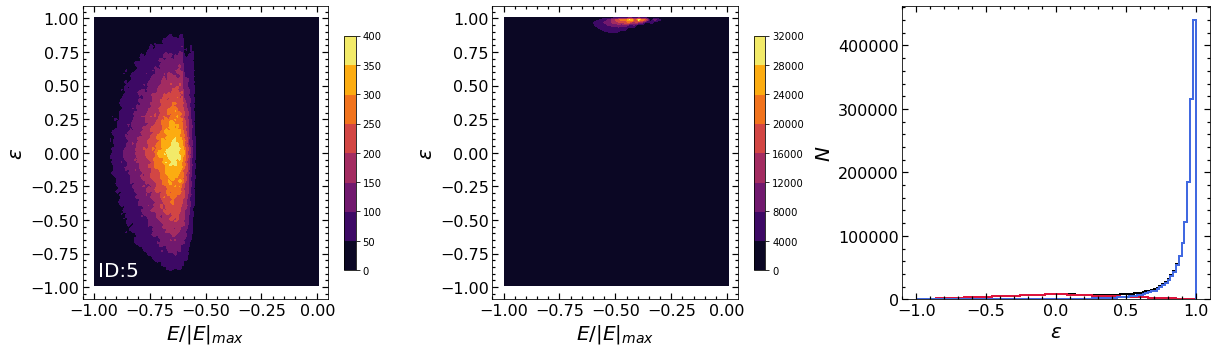

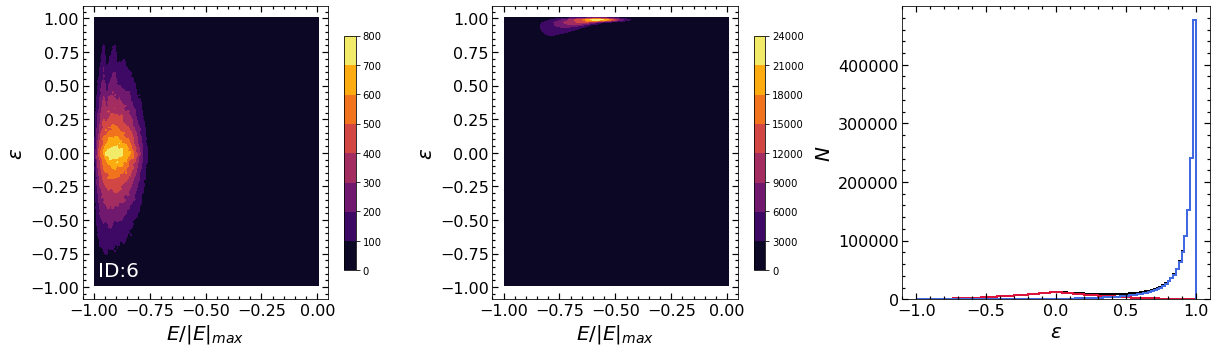

In [17]:
path = '/home/vcristiani/doctorado/test_agama/'
aux = np.loadtxt(path+'masa_y_R.dat')
R = aux[:,2]
M = aux[:,1]

Modelo = np.arange(1,7)

for ind in range(0,len(Modelo)):
    ## Leemos las estrellas de la galaxia
    s1 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_disk_final')
    s2 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_bulge_final')
    star = np.vstack((s1,s2))
    star[:,6] = star[:,6]/10**10
    
    ## Leemos los resultados de la descomposición dinámica del espacio circularidad - energia
    data = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/circularidad_y_L_M'+str(Modelo[ind])+'.dat')
    
    ## Calculamos la masa estelar total dentro de 3R_half
    r = np.sqrt(star[np.int_(data[:,0]),0]**2 + star[np.int_(data[:,0]),1]**2 + star[np.int_(data[:,0]),2]**2)
    corte_3R, = np.where(r <= 3.*R[ind])
    m_tot = np.sum(star[np.int_(data[:,0]),6][corte_3R])
    
    ## Leemos los resultados de la descomposicion dinamica en posiciones de las particulas 
    ## y calculamos la fraccion de masa estelar del disco y del esferoide
    esf = np.loadtxt(path+'desc_dina/esf_M'+str(Modelo[ind])+'.dat')
    esf = np.int_(esf)
    r = np.sqrt(star[esf,0]**2 + star[esf,1]**2 + star[esf,2]**2)
    corte_3R, = np.where(r <= 3.*R[ind])
    frac_masa_esf_3R[ind,0] = np.sum(star[esf,6][corte_3R])/m_tot
    
    dsk = np.loadtxt(path+'desc_dina/dsk_M'+str(Modelo[ind])+'.dat')
    dsk = np.int_(dsk)
    r = np.sqrt(star[dsk,0]**2 + star[dsk,1]**2 + star[dsk,2]**2)
    corte_3R, = np.where(r <= 3.*R[ind])
    frac_masa_dsk_3R[ind,0] = np.sum(star[dsk,6][corte_3R])/m_tot

    frac_masa_dsk[ind,0] = np.sum(star[dsk,6])/np.sum(star[np.int_(data[:,0]),6])
    frac_masa_esf[ind,0] = np.sum(star[esf,6])/np.sum(star[np.int_(data[:,0]),6])
    
    ## Leemos los resultados de la descomposición dinámica del espacio circularidad - energia de las componentes    
    esf = np.loadtxt(path+'desc_dina/circularidad_esf_M'+str(Modelo[ind])+'.dat')
    esf = np.int_(esf)
    dsk = np.loadtxt(path+'desc_dina/circularidad_dsk_M'+str(Modelo[ind])+'.dat')
    dsk = np.int_(dsk)
    
    ## Hacemos los plots de isocontornos de las dos componentes que separamos
    
    ## Construimos el grid con el que vamos a hacer los isocontornos
    ## Numero de celdas
    cel = 100.
    ## Limites
    xmin = -1.0
    xmax = 0.0
    ymin = -1.0
    ymax = 1.0

    ## Centros del grid
    xx = np.arange(0,np.int(cel)+1)*(xmax-xmin)/cel + xmin + (xmax-xmin)/(cel*2.)
    yy = np.arange(0,np.int(cel)+1)*(ymax-ymin)/cel + ymin + (ymax-ymin)/(cel*2.)

    ## Matriz donde vamos a guardar la suma de las particulas en cada celda
    Z1 = np.zeros((np.int(cel)+1,np.int(cel)+1))
    Z2 = np.zeros((np.int(cel)+1,np.int(cel)+1))

    ## Hacemos los plots de los isocontornos
    fig, ax1 = plt.subplots(1, 3, figsize=(17, 5), tight_layout=True)
    
    ## Veamos los indices de las celdas donde cae cada particula del esferoide
    i_x = np.int_(((data[esf,1]-xmin)/ (xmax-xmin))*cel)
    i_y = np.int_(((data[esf,2]-ymin)/ (ymax-ymin))*cel)

    ## Sumemos las contribuciones que hacen las particulas en cada celda
    for i in range(0,len(i_x)):
        Z1[i_y[i],i_x[i]] = Z1[i_y[i],i_x[i]] + 1

    CS = ax1[0].contourf(xx, yy, Z1,cmap='inferno')
    fig.colorbar(CS, ax=ax1[0],shrink=0.8,extend='both')
    ax1[0].text(-0.98,-0.92,r'ID:'+str('%1.0f'%ID[ind]),fontsize=20,color='w')
    
    ## Veamos los indices de las celdas donde cae cada particula del disco
    i_x = np.int_(((data[dsk,1]-xmin)/ (xmax-xmin))*cel)
    i_y = np.int_(((data[dsk,2]-ymin)/ (ymax-ymin))*cel)
    
    ## Sumemos las contribuciones que hacen las particulas en cada celda
    for i in range(0,len(i_x)):
            Z2[i_y[i],i_x[i]] = Z2[i_y[i],i_x[i]] + 1
    
    CS = ax1[1].contourf(xx, yy, Z2,cmap='inferno')
    fig.colorbar(CS, ax=ax1[1],shrink=0.8,extend='both')
    
    n_bin = 100
    ax1[2].hist(data[:,2],bins=n_bin,range=(-1,1),histtype='step',label=r'$total$',linewidth=2,color='k')
    ax1[2].hist(data[esf,2],bins=n_bin,range=(-1,1),histtype='step',label=r'$esferoide$',linewidth=2,color='crimson')
    ax1[2].hist(data[dsk,2],bins=n_bin,range=(-1,1),histtype='step',label=r'$discofino$',linewidth=2,color='royalblue')

    ax1[2].set_xlabel(r'$\epsilon$',fontsize=20)
    ax1[2].set_ylabel(r'$N$', fontsize=20)
    
    for i in range(0,2):
        ax1[i].set_xlabel(r'$E/|E|_{max}$', fontsize=20)
        ax1[i].set_ylabel(r'$\epsilon$',fontsize=20)
        ax1[i].set_xlim(-1.05,0.05)
        ax1[i].set_ylim(-1.09,1.09)    
    
    for i in range(0,3):
        ax1[i].minorticks_on()
        ax1[i].tick_params(labelsize=16)
        ax1[i].tick_params('both', length=3, width=1.2,which='minor', direction='in', right=True,top=True)
        ax1[i].tick_params('both', length=6, width=1.2,which='major', direction='in', right=True,top=True) 

    fig.savefig('/home/vcristiani/doctorado/test_agama/plot/cristiani_M'+str(Modelo[ind])+'.png', dpi = 100)

    plt.show()

# Descomposición GMM con 2 componentes

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import random

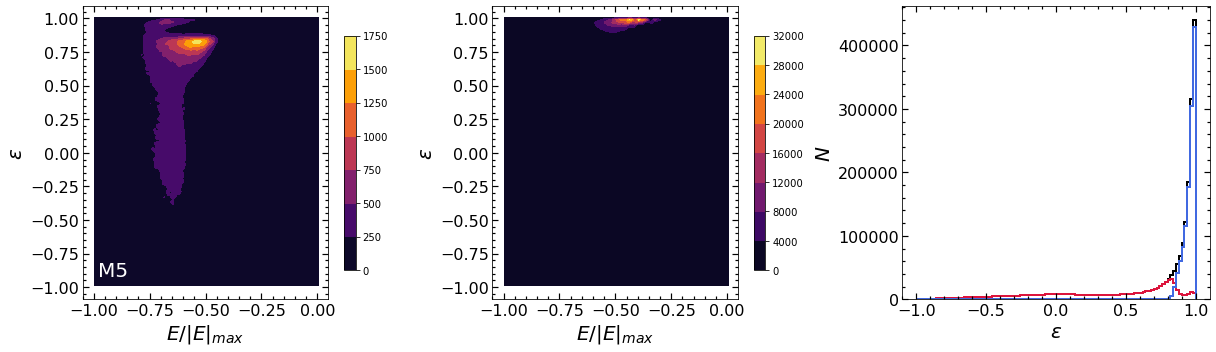

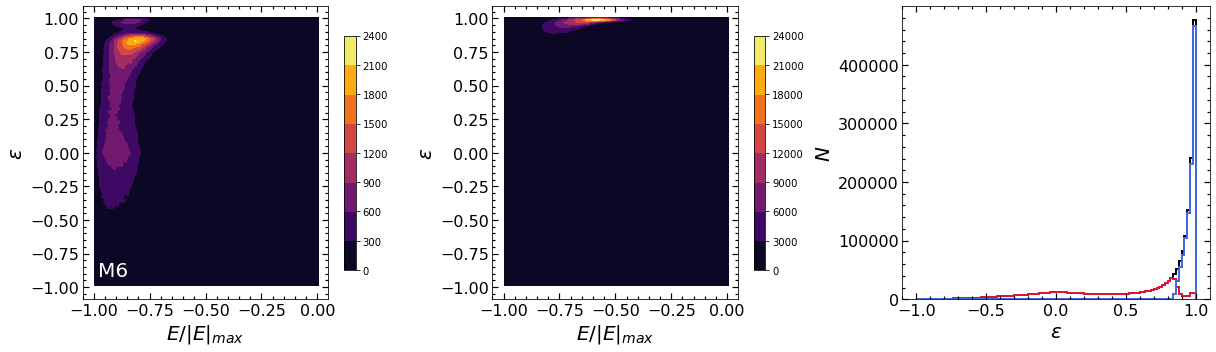

In [19]:
path = '/home/vcristiani/doctorado/test_agama/'
aux = np.loadtxt(path+'masa_y_R.dat')
R = aux[:,2]
M = aux[:,1]

Modelo = np.arange(1,7)

random.seed(2**32 - 1)

for ind in range(4,len(ID)):
    data = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/circularidad_y_L_M'+str(Modelo[ind])+'.dat')
    X_train = data[:,1:3]
    
    ## Aplicamos el GMM
    n_comp = 2 #--> nro de componentes
    
    clf_1 = GaussianMixture(n_components=n_comp, n_init=10)
    clf_1.fit(X_train)

    ## Clase asignada
    comp_1 = clf_1.predict(X_train)
    part0, = np.where(comp_1 == 0)
    part1, = np.where(comp_1 == 1)
    
    ## Centros de las clases
    cent_1 = clf_1.means_
    
    ## Probabilidad de pertenecer a cada clase
    pro_1 = clf_1.predict_proba(X_train)
    
    if cent_1[0,1] > cent_1[1,1]:
        dsk = pro_1[:,0]
        esf = pro_1[:,1]
    else:
        dsk = pro_1[:,1]
        esf = pro_1[:,0]
    
    ## Leemos las estrellas de la galaxia
    s1 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_disk_final')
    s2 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_bulge_final')
    star = np.vstack((s1,s2))
    star[:,6] = star[:,6]/10**10
    
    ## Calculamos la masa estelar total dentro de 3R_half
    r = np.sqrt(star[np.int_(data[:,0]),0]**2 + star[np.int_(data[:,0]),1]**2 + star[np.int_(data[:,0]),2]**2)
    corte_3R, = np.where(r <= 3.*R[ind])
    m_tot = np.sum(star[np.int_(data[:,0]),6][corte_3R])
    
    ## Calculamos la fraccion de masa estelar del disco y del esferoide
    frac_masa_esf_3R[ind,1] = np.sum(star[np.int_(data[:,0]),6][corte_3R]*esf[corte_3R])/m_tot
    frac_masa_dsk_3R[ind,1] = np.sum(star[np.int_(data[:,0]),6][corte_3R]*dsk[corte_3R])/m_tot    
    
    frac_masa_esf[ind,1] = np.sum(star[np.int_(data[:,0]),6]*esf)/np.sum(star[np.int_(data[:,0]),6])
    frac_masa_dsk[ind,1] = np.sum(star[np.int_(data[:,0]),6]*dsk)/np.sum(star[np.int_(data[:,0]),6])
    
    ## Guardamos los pesos de la descomposicion dinamica
    np.savetxt(path+'desc_dina/gmm2_esf_M'+str(ID[ind])+'.dat', esf, fmt=['%12.8f'])
    np.savetxt(path+'desc_dina/gmm2_dsk_M'+str(ID[ind])+'.dat', dsk, fmt=['%12.8f'])

    ## Hacemos el grid con el que vamos a hacer los isocontornos
    ## Numero de celdas
    cel = 100.
    ## Limites
    xmin = -1.0
    xmax = 0.0
    ymin = -1.0
    ymax = 1.0

    ## Centros del grid
    xx = np.arange(0,np.int(cel)+1)*(xmax-xmin)/cel + xmin + (xmax-xmin)/(cel*2.)
    yy = np.arange(0,np.int(cel)+1)*(ymax-ymin)/cel + ymin + (ymax-ymin)/(cel*2.)

    ## Matriz donde vamos a guardar la suma de las particulas en cada celda
    Z1 = np.zeros((np.int(cel)+1,np.int(cel)+1))
    Z2 = np.zeros((np.int(cel)+1,np.int(cel)+1))

    ## Veamos los indices de las celdas donde cae cada particula
    i_x = np.int_(((X_train[:,0]-xmin)/ (xmax-xmin))*cel)
    i_y = np.int_(((X_train[:,1]-ymin)/ (ymax-ymin))*cel)

    ## Sumemos las contribuciones que hacen las particulas en cada celda
    for i in range(0,len(i_x)):
        Z1[i_y[i],i_x[i]] = Z1[i_y[i],i_x[i]] + esf[i]
        Z2[i_y[i],i_x[i]] = Z2[i_y[i],i_x[i]] + dsk[i]
    
    ## Hacemos los plots de los isocontornos
    fig, ax1 = plt.subplots(1, 3, figsize=(17, 5), tight_layout=True)

    CS = ax1[0].contourf(xx, yy, Z1,cmap='inferno')
    fig.colorbar(CS, ax=ax1[0],shrink=0.8,extend='both')
    ax1[0].text(-0.98,-0.92,r'M'+str('%1.0f'%Modelo[ind]),fontsize=20,color='w',)
    
    CS = ax1[1].contourf(xx, yy, Z2,cmap='inferno')
    fig.colorbar(CS, ax=ax1[1],shrink=0.8,extend='both')
    
    n_bin = 100
    ax1[2].hist(data[:,2],bins=n_bin,range=(-1,1),weights=None,histtype='step',label=r'$total$',linewidth=2,color='k')
    ax1[2].hist(data[:,2],bins=n_bin,range=(-1,1),weights=esf[:],histtype='step',label=r'$total$',linewidth=2,color='crimson')
    ax1[2].hist(data[:,2],bins=n_bin,range=(-1,1),weights=dsk[:],histtype='step',label=r'$total$',linewidth=2,color='royalblue')
    ax1[2].set_xlabel(r'$\epsilon$',fontsize=20)
    ax1[2].set_ylabel(r'$N$', fontsize=20)
    
    for i in range(0,2):
        ax1[i].set_xlabel(r'$E/|E|_{max}$', fontsize=20)
        ax1[i].set_ylabel(r'$\epsilon$',fontsize=20)
        ax1[i].set_xlim(-1.05,0.05)
        ax1[i].set_ylim(-1.09,1.09)    
    
    for i in range(0,3):
        ax1[i].minorticks_on()
        ax1[i].tick_params(labelsize=16)
        ax1[i].tick_params('both', length=3, width=1.2,which='minor', direction='in', right=True,top=True)
        ax1[i].tick_params('both', length=6, width=1.2,which='major', direction='in', right=True,top=True) 

    fig.savefig('/home/vcristiani/doctorado/test_agama/plot/gmm2comp_M'+str(Modelo[ind])+'.png', dpi = 100)
    plt.show()

# GMM Du et al.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import random

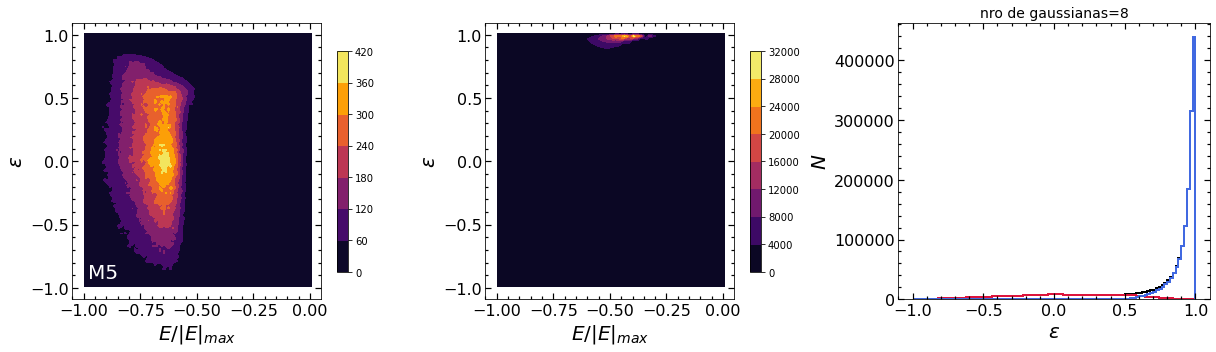

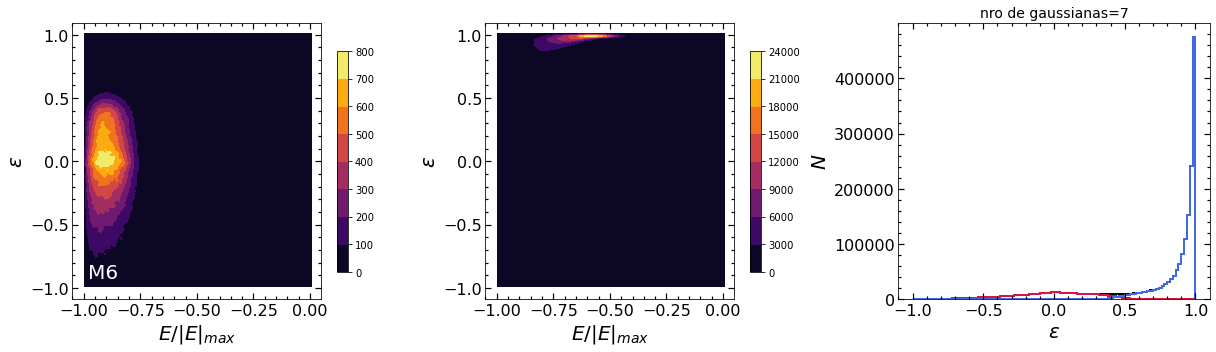

In [20]:
path = '/home/vcristiani/doctorado/test_agama/'
aux = np.loadtxt(path+'masa_y_R.dat')
R = aux[:,2]
M = aux[:,1]

Modelo = np.arange(1,7)

random.seed(2**32 - 1)

comp = np.arange(2,16)
BIC_med = np.zeros(len(comp))

for ind in range(0,len(Modelo)):
    data = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/circularidad_y_L_M'+str(Modelo[ind])+'.dat')
    X_train = data[:,1:3]
    
    ## Acá vamos de decidir cuantas componentes vamos a usar con el criterio de Du et al.
    for i in range(0,len(comp)):
        ## Aplicamos el GMM
        n_comp = comp[i]  #--> nro de componentes

        clf_1 = GaussianMixture(n_components=n_comp, n_init=1)
        clf_1.fit(X_train)
        BIC_med[i] = clf_1.bic(X_train)/len(X_train)
    
    BIC_min = np.sum(BIC_med[-5:])/5.
    delta_BIC = BIC_med - BIC_min

    C_BIC = 0.1
    mask, = np.where(delta_BIC <= C_BIC)
    n_comp = np.min(comp[mask]) #--> nro de componentes
    
    
    clf_1 = GaussianMixture(n_components=n_comp, n_init=10)
    clf_1.fit(X_train)

    ## Centros de las clases
    cent_1 = clf_1.means_
    
    ## Probabilidad de pertenecer a cada clase
    pro_1 = clf_1.predict_proba(X_train)

    ## Repartimos las probabilidades de los diferentes clusters en las componentes dinámicas
    ## Sub-componentes: esferoide y disco
    esf = np.zeros(len(X_train))
    dsk = np.zeros(len(X_train))

    for i in range(0,n_comp):
        if cent_1[i,1] >= 0.5:
            dsk = dsk + pro_1[:,i]
        if cent_1[i,1] < 0.5:
            esf = esf + pro_1[:,i]

    ## Leemos las estrellas de la galaxia
    s1 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_disk_final')
    s2 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_bulge_final')
    star = np.vstack((s1,s2))
    star[:,6] = star[:,6]/10**10
    
    ## Calculamos la masa estelar total dentro de 3R_half
    r = np.sqrt(star[np.int_(data[:,0]),0]**2 + star[np.int_(data[:,0]),1]**2 + star[np.int_(data[:,0]),2]**2)
    corte_3R, = np.where(r <= 3.*R[ind])
    m_tot = np.sum(star[np.int_(data[:,0]),6][corte_3R])
    
    ## Calculamos la fraccion de masa estelar del disco y del esferoide
    frac_masa_esf_3R[ind,2] = np.sum(star[np.int_(data[:,0]),6][corte_3R]*esf[corte_3R])/m_tot
    frac_masa_dsk_3R[ind,2] = np.sum(star[np.int_(data[:,0]),6][corte_3R]*dsk[corte_3R])/m_tot
    
    frac_masa_esf[ind,2] = np.sum(star[np.int_(data[:,0]),6]*esf)/np.sum(star[np.int_(data[:,0]),6])
    frac_masa_dsk[ind,2] = np.sum(star[np.int_(data[:,0]),6]*dsk)/np.sum(star[np.int_(data[:,0]),6])

    ## Guardamos los pesos de la descomposicion dinamica
    np.savetxt(path+'desc_dina/du_esf_M'+str(ID[ind])+'.dat', esf, fmt=['%12.8f'])
    np.savetxt(path+'desc_dina/du_dsk_M'+str(ID[ind])+'.dat', dsk, fmt=['%12.8f'])
    
    ## Hacemos el grid con el que vamos a hacer los isocontornos
    ## Numero de celdas
    cel = 100.
    ## Limites
    xmin = -1.0
    xmax = 0.0
    ymin = -1.0
    ymax = 1.0

    ## Centros del grid
    xx = np.arange(0,np.int(cel)+1)*(xmax-xmin)/cel + xmin + (xmax-xmin)/(cel*2.)
    yy = np.arange(0,np.int(cel)+1)*(ymax-ymin)/cel + ymin + (ymax-ymin)/(cel*2.)

    ## Matriz donde vamos a guardar la suma de las particulas en cada celda
    Z1 = np.zeros((np.int(cel)+1,np.int(cel)+1))
    Z2 = np.zeros((np.int(cel)+1,np.int(cel)+1))

    ## Veamos los indices de las celdas donde cae cada particula
    i_x = np.int_(((X_train[:,0]-xmin)/ (xmax-xmin))*cel)
    i_y = np.int_(((X_train[:,1]-ymin)/ (ymax-ymin))*cel)

    ## Sumemos las contribuciones que hacen las particulas en cada celda
    for i in range(0,len(i_x)):
        Z1[i_y[i],i_x[i]] = Z1[i_y[i],i_x[i]] + esf[i]
        Z2[i_y[i],i_x[i]] = Z2[i_y[i],i_x[i]] + dsk[i]
    
    ## Hacemos los plots de los isocontornos
    fig, ax1 = plt.subplots(1, 3, figsize=(17, 5), tight_layout=True)

    CS = ax1[0].contourf(xx, yy, Z1,cmap='inferno')
    fig.colorbar(CS, ax=ax1[0],shrink=0.8,extend='both')
    ax1[0].text(-0.98,-0.92,r'M'+str('%1.0f'%Modelo[ind]),fontsize=20,color='w',)
    
    CS = ax1[1].contourf(xx, yy, Z2,cmap='inferno')
    fig.colorbar(CS, ax=ax1[1],shrink=0.8,extend='both')
    
    n_bin = 100
    ax1[2].hist(data[:,2],bins=n_bin,range=(-1,1),weights=None,histtype='step',label=r'$total$',linewidth=2,color='k')
    ax1[2].hist(data[:,2],bins=n_bin,range=(-1,1),weights=esf[:],histtype='step',label=r'$total$',linewidth=2,color='crimson')
    ax1[2].hist(data[:,2],bins=n_bin,range=(-1,1),weights=dsk[:],histtype='step',label=r'$total$',linewidth=2,color='royalblue')
    ax1[2].set_xlabel(r'$\epsilon$',fontsize=20)
    ax1[2].set_ylabel(r'$N$', fontsize=20)
    ax1[2].set_title(r'nro de gaussianas='+str('%1.0f'%n_comp),fontsize=14,color='k',)
    
    for i in range(0,2):
        ax1[i].set_xlabel(r'$E/|E|_{max}$', fontsize=20)
        ax1[i].set_ylabel(r'$\epsilon$',fontsize=20)
        ax1[i].set_xlim(-1.05,0.05)
        ax1[i].set_ylim(-1.09,1.09)    
    
    for i in range(0,3):
        ax1[i].minorticks_on()
        ax1[i].tick_params(labelsize=16)
        ax1[i].tick_params('both', length=3, width=1.2,which='minor', direction='in', right=True,top=True)
        ax1[i].tick_params('both', length=6, width=1.2,which='major', direction='in', right=True,top=True) 

    fig.savefig('/home/vcristiani/doctorado/test_agama/plot/gmmDU_ID_'+str(Modelo[ind])+'.png', dpi = 100)
    plt.show()

In [16]:
frac_masa_dsk
frac_masa_esf

array([[0.32067412, 0.46431395, 0.34215159, 0.33905862],
       [0.27185546, 0.42418738, 0.29526254, 0.28090426],
       [0.33133254, 0.42376205, 0.27871882, 0.34444958],
       [0.33064721, 0.41680164, 0.27547107, 0.34370469]])

# Fracciones de masa de las componentes

In [20]:
np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/fraccion_masa_dsk.dat', frac_masa_dsk, fmt=['%12.8f','%12.8f','%12.8f','%12.8f'])
np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/fraccion_masa_esf.dat', frac_masa_esf, fmt=['%12.8f','%12.8f','%12.8f','%12.8f'])

np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/fraccion_masa_dsk_3R.dat', frac_masa_dsk_3R, fmt=['%12.8f','%12.8f','%12.8f','%12.8f'])
np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/fraccion_masa_esf_3R.dat', frac_masa_esf_3R, fmt=['%12.8f','%12.8f','%12.8f','%12.8f'])

In [28]:
frac_masa_dsk = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/fraccion_masa_dsk.dat')
frac_masa_esf = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/fraccion_masa_esf.dat')

frac_masa_dsk_3R = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/fraccion_masa_dsk_3R.dat')
frac_masa_esf_3R = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/fraccion_masa_esf_3R.dat')

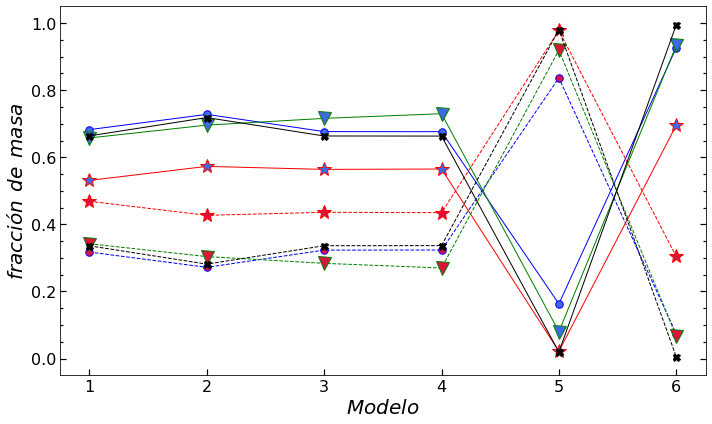

In [29]:
ID = np.arange(1,7)
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)

## Cristiani
ax.plot(Modelo,frac_masa_dsk[:,0],marker='.',linestyle='-',color='b',markerfacecolor='royalblue',ms=15,lw=1)
ax.plot(Modelo,frac_masa_esf[:,0],marker='.',linestyle='--',color='b',markerfacecolor='crimson',ms=15,lw=1)

## GMM 2 comp
ax.plot(Modelo,frac_masa_dsk[:,1],marker='*',linestyle='-',color='r',markerfacecolor='royalblue',ms=15,lw=1)
ax.plot(Modelo,frac_masa_esf[:,1],marker='*',linestyle='--',color='r',markerfacecolor='crimson',ms=15,lw=1)

## DU 2 comp
ax.plot(Modelo,frac_masa_dsk[:,2],marker='v',linestyle='-',color='g',markerfacecolor='royalblue',ms=13,lw=1)
ax.plot(Modelo,frac_masa_esf[:,2],marker='v',linestyle='--',color='g',markerfacecolor='crimson',ms=13,lw=1)

## Fracciones de masa originales
ax.plot(Modelo,frac_masa_dsk[:,3],marker='X',linestyle='-',color='k',ms=7,lw=1.)
ax.plot(Modelo,frac_masa_esf[:,3],marker='X',linestyle='--',color='k',ms=7,lw=1.)

ax.set_xlabel(r'$Modelo$', fontsize=20)
ax.set_ylabel(r'$fracción\:\:de\:\:masa$',fontsize=20)

ax.set_ylim(-0.05,1.05)

positions = Modelo
labels = ID
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax.minorticks_on()
ax.tick_params(labelsize=16)
ax.tick_params('y', length=3, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('y', length=6, width=1.2,which='major', direction='in', right=True,top=True)

ax.tick_params('x', length=6, width=1.2,which='major', direction='in', right=True,top=False)
ax.tick_params('x', length=0, width=1.2,which='minor', direction='in', right=True,top=True)

fig.savefig('/home/vcristiani/doctorado/test_agama/plot/fracc_masa_.png', dpi = 100)

plt.show()

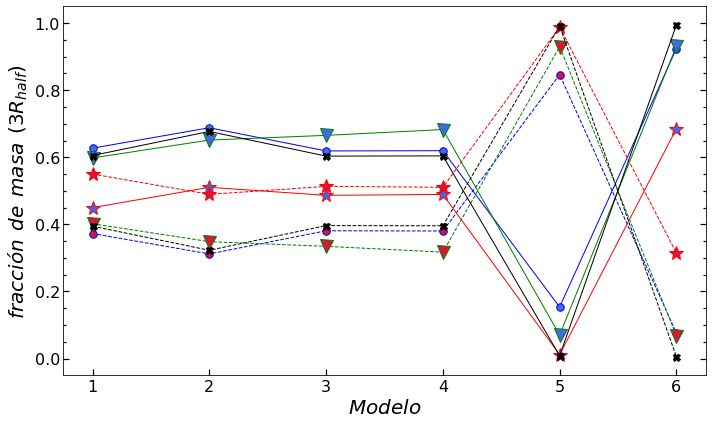

In [30]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)

## Cristiani
ax.plot(Modelo,frac_masa_dsk_3R[:,0],marker='.',linestyle='-',color='b',markerfacecolor='royalblue',ms=15,lw=1)
ax.plot(Modelo,frac_masa_esf_3R[:,0],marker='.',linestyle='--',color='b',markerfacecolor='crimson',ms=15,lw=1)

## GMM 2 comp
ax.plot(Modelo,frac_masa_dsk_3R[:,1],marker='*',linestyle='-',color='r',markerfacecolor='royalblue',ms=15,lw=1)
ax.plot(Modelo,frac_masa_esf_3R[:,1],marker='*',linestyle='--',color='r',markerfacecolor='crimson',ms=15,lw=1)

## DU 2 comp
ax.plot(Modelo,frac_masa_dsk_3R[:,2],marker='v',linestyle='-',color='g',markerfacecolor='royalblue',ms=13,lw=1)
ax.plot(Modelo,frac_masa_esf_3R[:,2],marker='v',linestyle='--',color='g',markerfacecolor='crimson',ms=13,lw=1)

## Fracciones de masa originales
ax.plot(Modelo,frac_masa_dsk_3R[:,3],marker='X',linestyle='-',color='k',ms=7,lw=1.)
ax.plot(Modelo,frac_masa_esf_3R[:,3],marker='X',linestyle='--',color='k',ms=7,lw=1.)

ax.set_xlabel(r'$Modelo$', fontsize=20)
ax.set_ylabel(r'$fracción\:\:de\:\:masa\:\:(3R_{half})$',fontsize=20)

ax.set_ylim(-0.05,1.05)

positions = Modelo
labels = ID
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax.minorticks_on()
ax.tick_params(labelsize=16)
ax.tick_params('y', length=3, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('y', length=6, width=1.2,which='major', direction='in', right=True,top=True)

ax.tick_params('x', length=6, width=1.2,which='major', direction='in', right=True,top=False)
ax.tick_params('x', length=0, width=1.2,which='minor', direction='in', right=True,top=True)

fig.savefig('/home/vcristiani/doctorado/test_agama/plot/fracc_masa_3R_.png', dpi = 100)

plt.show()

# Perfil de Densidad de masa

In [31]:
%pylab inline
from equal_number import *
from dens import *

Populating the interactive namespace from numpy and matplotlib


/home/vcristiani/packages/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 're', 'sort', 'stack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


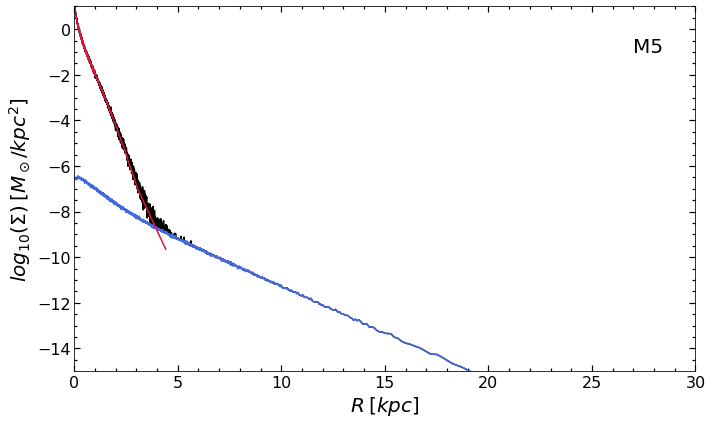

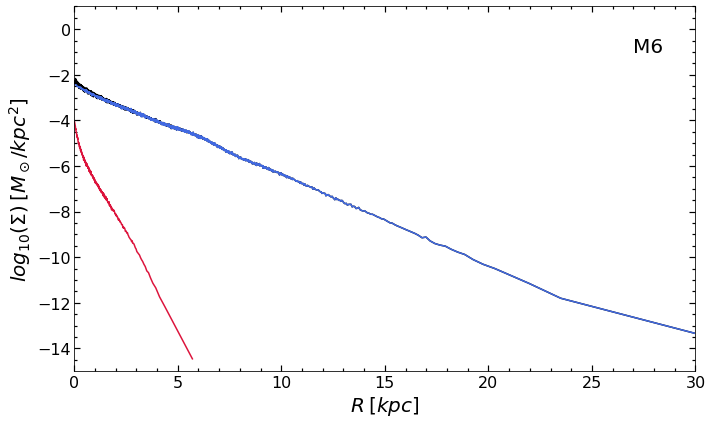

In [32]:
## Perfil de densidad de la galaxia

path = '/home/vcristiani/doctorado/test_agama/'
aux = np.loadtxt(path+'masa_y_R.dat')
R = aux[:,2]
M = aux[:,1]

Modelo = np.arange(1,7)

for ind in range(4,len(Modelo)):
    ## Leemos las estrellas de la galaxia
    s1 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_disk_final')
    s2 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_bulge_final')
    star = np.vstack((s1,s2))
    star[:,6] = star[:,6]/10**10
    
    ## Perfil en 2D total
    R_part = (np.sqrt(star[:,0]**2 + star[:,1]**2)) # Radio cilindrico de las particulas
    R0, Rbin_equ = rbin2(R_part,1000) # Bineado equal number de 1000 particulas
    R_densidad2D, densidad2D = dens_2D(R_part, Rbin_equ, star[:,6]) # calculamos el perfil de densidad

    ## Perfil en 2D disco
    R_part_dsk = (np.sqrt(s1[:,0]**2 + s1[:,1]**2)) # Radio cilindrico de las particulas
    R0, Rbin_equ_dsk = rbin2(R_part_dsk,1000) # Bineado equal number de 1000 particulas
    R_densidad2D_dsk, densidad2D_dsk = dens_2D(R_part_dsk, Rbin_equ_dsk, s1[:,6]/10**10) # calculamos el perfil de densidad

    ## Perfil en 2D esferoide
    R_part_esf = (np.sqrt(s2[:,0]**2 + s2[:,1]**2)) # Radio cilindrico de las particulas
    R0, Rbin_equ_esf = rbin2(R_part_esf,1000) # Bineado equal number de 1000 particulas
    R_densidad2D_esf, densidad2D_esf = dens_2D(R_part_esf, Rbin_equ_esf, s2[:,6]/10**10) # calculamos el perfil de densidad
    
    ## Hacemos el plot de los perfiles de densidad
    fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
    
    ax.text(27,-1,r'M'+str('%1.0f'%Modelo[ind]),fontsize=20,color='k')
    ax.plot(R_densidad2D,np.log(densidad2D),'k')
    ax.plot(R_densidad2D_dsk,np.log(densidad2D_dsk),color='royalblue')
    ax.plot(R_densidad2D_esf,np.log(densidad2D_esf),color='crimson')
    
    ax.set_xlim(0,30)
    ax.set_ylim(-15,1)
    
    ax.set_xlabel(r'$R\:[kpc]$', fontsize=20)
    ax.set_ylabel(r'$log_{10}(\Sigma)\:[M_\odot/kpc^2]$', fontsize=20)

    ax.minorticks_on()
    ax.tick_params(labelsize=16)
    ax.tick_params('both', length=3, width=1.2,which='minor', direction='in', right=True,top=True)
    ax.tick_params('both', length=6, width=1.2,which='major', direction='in', right=True,top=True)

    fig.savefig('/home/vcristiani/doctorado/test_agama/plot/densidad_M'+str(Modelo[ind])+'.png', dpi = 100)
    plt.show()

In [34]:
path = '/home/vcristiani/doctorado/test_agama/'
aux = np.loadtxt(path+'masa_y_R.dat')
R = aux[:,2]
M = aux[:,1]

Modelo = np.arange(1,7)

for ind in range(0,len(Modelo)):
    ## Leemos las estrellas de la galaxia
    s1 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_disk_final')
    s2 = np.loadtxt('/home/vcristiani/doctorado/test_agama/out/M'+str(Modelo[ind])+'/model_bulge_final')
    star = np.vstack((s1,s2))
    star[:,6] = star[:,6]/10**10
        
    ## Leemos los resultados de la descomposicion dinamica en posiciones de las particulas 
    dsk = np.loadtxt(path+'desc_dina/dsk_M'+str(Modelo[ind])+'.dat')
    dsk = np.int_(dsk)
    
    esf = np.loadtxt(path+'desc_dina/esf_M'+str(Modelo[ind])+'.dat')
    esf = np.int_(esf)
        
    data = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/circularidad_y_L_M'+str(Modelo[ind])+'.dat')
    
    dsk_gmm2 = np.loadtxt(path+'desc_dina/gmm2_dsk_M'+str(Modelo[ind])+'.dat')
    esf_gmm2 = np.loadtxt(path+'desc_dina/gmm2_esf_M'+str(Modelo[ind])+'.dat')
    
    dsk_du = np.loadtxt(path+'desc_dina/du_dsk_M'+str(Modelo[ind])+'.dat')
    esf_du = np.loadtxt(path+'desc_dina/du_esf_M'+str(Modelo[ind])+'.dat')
        
    ## Calculamos los perfiles para el disco ######################################################################################################################
    R_part_dsk = (np.sqrt(s1[:,0]**2 + s1[:,1]**2))  # Radio cilindrico de las particulas
    R0, Rbin_equ_dsk = rbin2(R_part_dsk,1000)        # Bineado equal number de 1000 particulas
    R_densidad2D_dsk, densidad2D_dsk = dens_2D(R_part_dsk, Rbin_equ_dsk, s1[:,6]/10**10) # Calculamos el perfil de densidad

    R_part_dsk_c = (np.sqrt(star[dsk,0]**2 + star[dsk,1]**2))  # Radio cilindrico de las particulas
    R0, Rbin_equ = rbin2(R_part_dsk_c,1000)                    # Bineado equal number de 1000 particulas
    R_densidad2D_dsk_c, densidad2D_dsk_c = dens_2D(R_part_dsk_c, Rbin_equ, star[dsk,6]) # Calculamos el perfil de densidad

    R_part_dsk_gmm2 = (np.sqrt(star[np.int_(data[:,0]),0]**2 + star[np.int_(data[:,0]),1]**2))  # Radio cilindrico de las particulas
    R0, Rbin_equ = rbin2(R_part_dsk_gmm2,1000)                    # Bineado equal number de 1000 particulas
    R_densidad2D_dsk_gmm2, densidad2D_dsk_gmm2 = dens_2D(R_part_dsk_gmm2, Rbin_equ, star[np.int_(data[:,0]),6]*dsk_gmm2) # Calculamos el perfil de densidad
    
    R_part_dsk_du = (np.sqrt(star[np.int_(data[:,0]),0]**2 + star[np.int_(data[:,0]),1]**2))  # Radio cilindrico de las particulas
    R0, Rbin_equ = rbin2(R_part_dsk_du,1000)                    # Bineado equal number de 1000 particulas
    R_densidad2D_dsk_du, densidad2D_dsk_du = dens_2D(R_part_dsk_du, Rbin_equ, star[np.int_(data[:,0]),6]*dsk_du) # Calculamos el perfil de densidad
    
    ## Calculamos los perfiles para el bulge ######################################################################################################################
    R_part_esf = (np.sqrt(s2[:,0]**2 + s2[:,1]**2))  # Radio cilindrico de las particulas
    R0, Rbin_equ_esf = rbin2(R_part_esf,1000)        # Bineado equal number de 1000 particulas
    R_densidad2D_esf, densidad2D_esf = dens_2D(R_part_esf, Rbin_equ_esf, s2[:,6]/10**10) # Calculamos el perfil de densidad
    
    R_part_esf_c = (np.sqrt(star[esf,0]**2 + star[esf,1]**2))  # Radio cilindrico de las particulas
    R0, Rbin_equ = rbin2(R_part_esf_c,1000)                    # Bineado equal number de 1000 particulas
    R_densidad2D_esf_c, densidad2D_esf_c = dens_2D(R_part_esf_c, Rbin_equ, star[esf,6]) # Calculamos el perfil de densidad
    
    R_part_esf_gmm2 = (np.sqrt(star[np.int_(data[:,0]),0]**2 + star[np.int_(data[:,0]),1]**2))  # Radio cilindrico de las particulas
    R0, Rbin_equ = rbin2(R_part_esf_gmm2,1000)                    # Bineado equal number de 1000 particulas
    R_densidad2D_esf_gmm2, densidad2D_esf_gmm2 = dens_2D(R_part_esf_gmm2, Rbin_equ, star[np.int_(data[:,0]),6]*esf_gmm2) # Calculamos el perfil de densidad
    
    R_part_esf_du = (np.sqrt(star[np.int_(data[:,0]),0]**2 + star[np.int_(data[:,0]),1]**2))  # Radio cilindrico de las particulas
    R0, Rbin_equ = rbin2(R_part_esf_du,1000)                    # Bineado equal number de 1000 particulas
    R_densidad2D_esf_du, densidad2D_esf_du = dens_2D(R_part_esf_du, Rbin_equ, star[np.int_(data[:,0]),6]*esf_du) # Calculamos el perfil de densidad
    
    ## Guardamos los datos de salida
    aux1 = np.vstack((R_densidad2D_dsk, densidad2D_dsk))
    aux2 = np.vstack((R_densidad2D_dsk_c, densidad2D_dsk_c))
    aux3 = np.vstack((R_densidad2D_dsk_gmm2, densidad2D_dsk_gmm2))
    aux4 = np.vstack((R_densidad2D_dsk_du, densidad2D_dsk_du))
    np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_dsk.dat', aux1.T, fmt=['%12.8f','%12.8f'])
    np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_dsk_c.dat', aux2.T, fmt=['%12.8f','%12.8f'])
    np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_dsk_gmm2.dat', aux3.T, fmt=['%12.8f','%12.8f'])
    np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_dsk_du.dat', aux4.T, fmt=['%12.8f','%12.8f'])
    
    aux1 = np.vstack((R_densidad2D_esf, densidad2D_esf))
    aux2 = np.vstack((R_densidad2D_esf_c, densidad2D_esf_c))
    aux3 = np.vstack((R_densidad2D_esf_gmm2, densidad2D_esf_gmm2))
    aux4 = np.vstack((R_densidad2D_esf_du, densidad2D_esf_du))
    np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_esf.dat', aux1.T, fmt=['%12.8f','%12.8f'])
    np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_esf_c.dat', aux2.T, fmt=['%12.8f','%12.8f'])
    np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_esf_gmm2.dat', aux3.T, fmt=['%12.8f','%12.8f'])
    np.savetxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_esf_du.dat', aux4.T, fmt=['%12.8f','%12.8f'])

/home/vcristiani/packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/vcristiani/packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


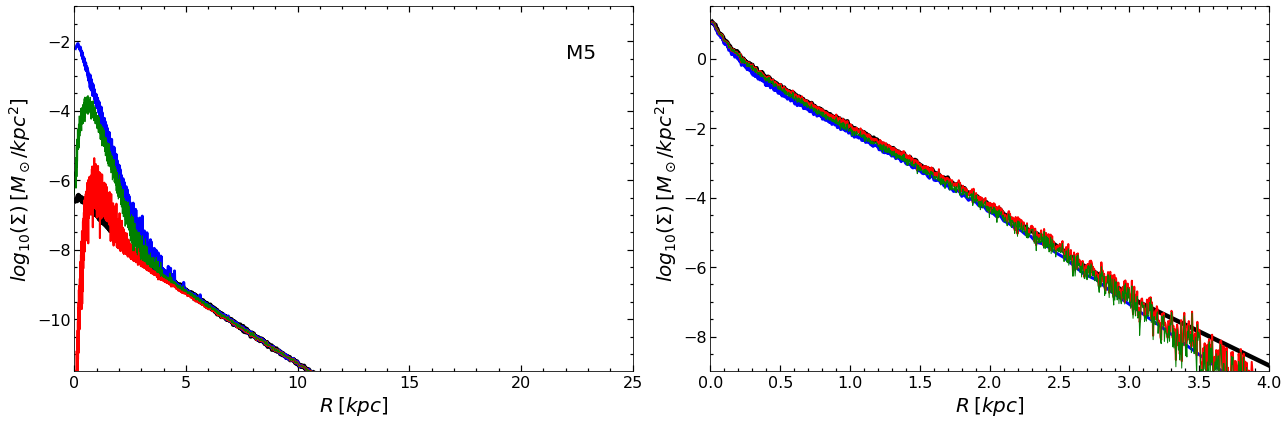

/home/vcristiani/packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/vcristiani/packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


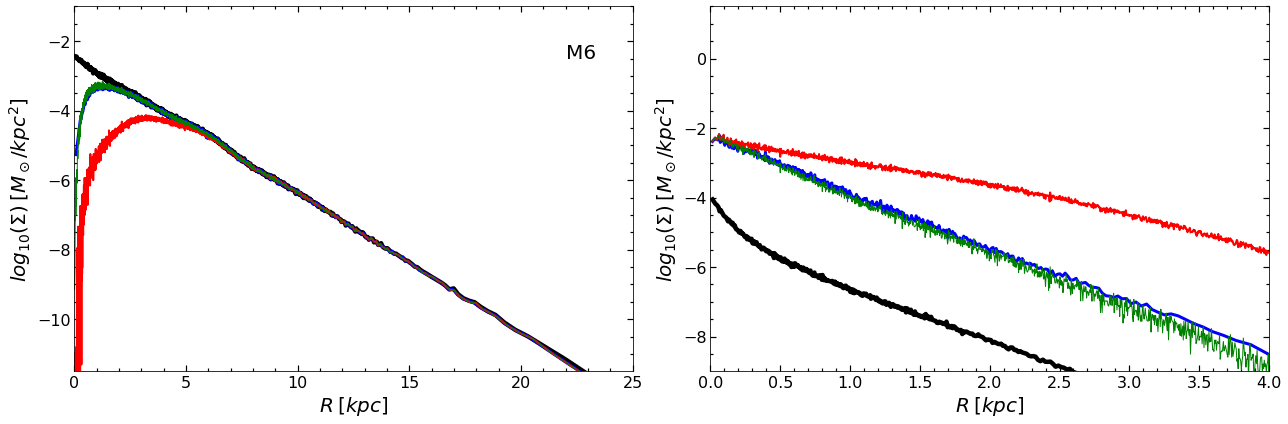

In [35]:
path = '/home/vcristiani/doctorado/test_agama/'
Modelo = np.arange(1,7)

for ind in range(0,len(Modelo)):
    ## Leemos los datos de salida
    aux1d = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_dsk.dat')
    aux2d = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_dsk_c.dat')
    aux3d = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_dsk_gmm2.dat')
    aux4d = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_dsk_du.dat')
    
    R_densidad2D_dsk = aux1d[:,0]
    R_densidad2D_dsk_c = aux2d[:,0]
    R_densidad2D_dsk_gmm2 = aux3d[:,0]
    R_densidad2D_dsk_du = aux4d[:,0]
    
    densidad2D_dsk = aux1d[:,1]
    densidad2D_dsk_c = aux2d[:,1]
    densidad2D_dsk_gmm2 = aux3d[:,1]
    densidad2D_dsk_du = aux4d[:,1]
    
    aux1e = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_esf.dat')
    aux2e = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_esf_c.dat')
    aux3e = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_esf_gmm2.dat')
    aux4e = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_esf_du.dat')
    
    R_densidad2D_esf = aux1e[:,0]
    R_densidad2D_esf_c = aux2e[:,0]
    R_densidad2D_esf_gmm2 = aux3e[:,0]
    R_densidad2D_esf_du = aux4e[:,0]
    
    densidad2D_esf = aux1e[:,1]
    densidad2D_esf_c = aux2e[:,1]
    densidad2D_esf_gmm2 = aux3e[:,1]
    densidad2D_esf_du = aux4e[:,1]

    ## Hacemos los plots de los perfiles
    fig, ax = plt.subplots(1,2, figsize=(18, 6), tight_layout=True)

    ax[0].text(22,-2.5,r'M'+str('%1.0f'%Modelo[ind]),fontsize=20,color='k')
    ax[0].plot(R_densidad2D_dsk,np.log(densidad2D_dsk),'k',lw=4.5)
    ax[0].plot(R_densidad2D_dsk_c,np.log(densidad2D_dsk_c),color='b',lw=3)
    ax[0].plot(R_densidad2D_dsk_gmm2,np.log(densidad2D_dsk_gmm2),color='r',lw=2)
    ax[0].plot(R_densidad2D_dsk_du,np.log(densidad2D_dsk_du),color='g',lw=1)
    
    
    
    ax[0].set_xlim(0,25)
    ax[0].set_ylim(-11.5,-1)
    ax[0].set_xlabel(r'$R\:[kpc]$', fontsize=20)
    ax[0].set_ylabel(r'$log_{10}(\Sigma)\:[M_\odot/kpc^2]$', fontsize=20)

    ax[1].plot(R_densidad2D_esf,np.log(densidad2D_esf),'k',lw=4.5)
    ax[1].plot(R_densidad2D_esf_c,np.log(densidad2D_esf_c),color='b',lw=3)
    ax[1].plot(R_densidad2D_esf_gmm2,np.log(densidad2D_esf_gmm2),color='r',lw=2)
    ax[1].plot(R_densidad2D_esf_du,np.log(densidad2D_esf_du),color='g',lw=1)
    
    
    
    ax[1].set_xlim(0,4)
    ax[1].set_ylim(-9,1.5)
    ax[1].set_xlabel(r'$R\:[kpc]$', fontsize=20)
    ax[1].set_ylabel(r'$log_{10}(\Sigma)\:[M_\odot/kpc^2]$', fontsize=20)

    for i in range(0,2):
        ax[i].minorticks_on()
        ax[i].tick_params(labelsize=16)
        ax[i].tick_params('both', length=3, width=1.2,which='minor', direction='in', right=True,top=True)
        ax[i].tick_params('both', length=6, width=1.2,which='major', direction='in', right=True,top=True)
        
    fig.savefig('/home/vcristiani/doctorado/test_agama/plot/densidad_de_masa_M'+str(Modelo[ind])+'.png', dpi = 100)

    plt.show()

In [75]:
from scipy import integrate
path = '/home/vcristiani/doctorado/test_agama/'
Modelo = np.arange(1,5)

fmd = np.zeros((4,4))
fme = np.zeros((4,4))

In [83]:
for ind in range(0,len(Modelo)):
    ## Leemos los datos de salida
    aux1d = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_dsk.dat')
    aux2d = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_dsk_c.dat')
    aux3d = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_dsk_gmm2.dat')
    aux4d = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_dsk_du.dat')
    
    aux1e = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_esf.dat')
    aux2e = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_esf_c.dat')
    aux3e = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_esf_gmm2.dat')
    aux4e = np.loadtxt('/home/vcristiani/doctorado/test_agama/desc_dina/densidad_de_masa_M'+str(Modelo[ind])+'_esf_du.dat')

    fmd[ind,0] = integrate.simps(aux1d[:,1],aux1d[:,0])
    fmd[ind,1] = integrate.simps(aux2d[:,1],aux2d[:,0])
    fmd[ind,2] = integrate.simps(aux3d[:,1],aux3d[:,0])
    fmd[ind,3] = integrate.simps(aux4d[:,1],aux4d[:,0])
    
    fme[ind,0] = integrate.simps(aux1e[:,1],aux1e[:,0])
    fme[ind,1] = integrate.simps(aux2e[:,1],aux2e[:,0])
    fme[ind,2] = integrate.simps(aux3e[:,1],aux3e[:,0])
    fme[ind,3] = integrate.simps(aux4e[:,1],aux4e[:,0])

In [84]:
# Un modelo, todos lo metodos
fmd[0,:]

array([0.26864695, 0.28883925, 0.12988049, 0.23720625])

In [85]:
# Un modelo, todos los metodos
fme[0,:]

array([0.70996541, 0.68819228, 0.85163873, 0.74431299])

In [86]:
fmd

array([[0.26864695, 0.28883925, 0.12988049, 0.23720625],
       [0.3436434 , 0.35005293, 0.1600756 , 0.28649615],
       [0.26550591, 0.28738225, 0.15955562, 0.35762634],
       [0.25987936, 0.28045712, 0.16239465, 0.35986181]])

In [87]:
fme

array([[0.70996541, 0.68819228, 0.85163873, 0.74431299],
       [0.70317571, 0.69698905, 0.89107343, 0.76465289],
       [0.70322758, 0.67588962, 0.80833482, 0.61026411],
       [0.6925233 , 0.66581593, 0.78929436, 0.59182719]])

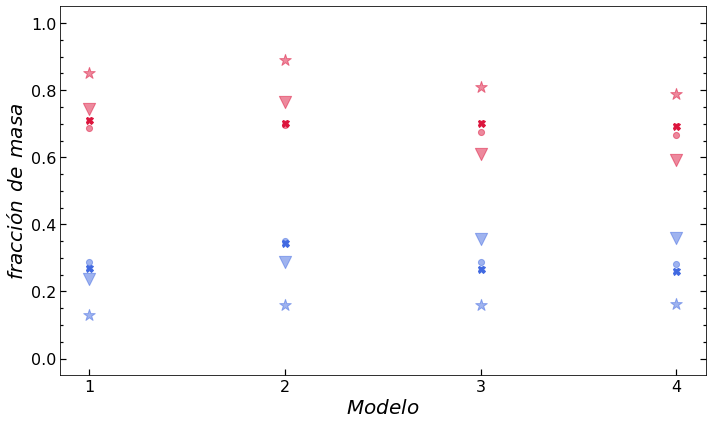

In [92]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)

## Fracciones de masa originales
ax.plot(Modelo,fmd[:,0],'X',color='royalblue',ms=7)
ax.plot(Modelo,fme[:,0],'X',color='crimson',ms=7)

## Cristiani
ax.scatter(Modelo,fmd[:,1],marker='.',color='royalblue',s=150, alpha=0.5)
ax.scatter(Modelo,fme[:,1],marker='.',color='crimson',s=150, alpha=0.5)

## GMM 2 comp
ax.scatter(Modelo,fmd[:,2],marker='*',color='royalblue',s=150, alpha=0.5)
ax.scatter(Modelo,fme[:,2],marker='*',color='crimson',s=150, alpha=0.5)

## DU 2 comp
ax.scatter(Modelo,fmd[:,3],marker='v',color='royalblue',s=150, alpha=0.5)
ax.scatter(Modelo,fme[:,3],marker='v',color='crimson',s=150, alpha=0.5)

ax.set_xlabel(r'$Modelo$', fontsize=20)
ax.set_ylabel(r'$fracción\:\:de\:\:masa$',fontsize=20)

ax.set_ylim(-0.05,1.05)

positions = Modelo
labels = ID
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax.minorticks_on()
ax.tick_params(labelsize=16)
ax.tick_params('y', length=3, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('y', length=6, width=1.2,which='major', direction='in', right=True,top=True)

ax.tick_params('x', length=6, width=1.2,which='major', direction='in', right=True,top=False)
ax.tick_params('x', length=0, width=1.2,which='minor', direction='in', right=True,top=True)

# fig.savefig('/home/vcristiani/doctorado/test_agama/plot/fracc_masa.png', dpi = 100)

plt.show()